# EE960: AI in IoT - Assignment Task 2  
## Smart Monitoring System: Temperature Prediction Model

**Objective:**  
Design a regression model to predict the **mean temperature of a week** based on 5 years of historical temperature and humidity data.

We use a **Random Forest Regressor** and incorporate **lagged time-series features** to improve predictive accuracy.

**Dataset Split:**  
We use a *chronological split* → **Train: 2015–2019 (~80%)**, **Test: 2020 (~20%)**, ensuring no leakage from future data.

---


In [1]:
# 1. Import required libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

# 2. Load dataset
# Ensure 'Temp_and_humidity_dataset.csv' is in the same directory as this notebook.
df = pd.read_csv("Temp_and_humidity_dataset.csv")

# Standardize column names
df.columns = [col.strip().upper() for col in df.columns]

# Quick sanity check
print("Columns:", df.columns.tolist())
print("First few rows:")
print(df.head())


Columns: ['DATETIME', 'TEMPERATURE', 'HUMIDITY']
First few rows:
              DATETIME  TEMPERATURE  HUMIDITY
0  2015-01-01 00:00:00         19.0      75.0
1  2015-01-01 01:00:00         19.0      77.0
2  2015-01-01 02:00:00         19.0      78.0
3  2015-01-01 03:00:00         19.0      80.0
4  2015-01-01 04:00:00         19.0      81.0


## Weekly Aggregation & Feature Engineering

The raw dataset contains **hourly readings** of temperature and humidity.  
To align with the assignment requirement:

> *"...design a machine learning model that can predict the temperature of a week of any specific month."*

we convert the data into **weekly aggregates**:

- `TEMP_MEAN` → Average temperature of the week *(target variable)*  
- `HUM_MEAN` → Average humidity of the week *(input feature)*  
- `MONTH` → Representative month for the week (from the first timestamp)  
- `TEMP_MEAN_LAG_1` → Previous week's mean temperature *(lagged feature)*  
- `HUM_MEAN_LAG_1` → Previous week's mean humidity *(lagged feature)*  

Lagged features help capture **temporal dependence**, improving forecast quality.


In [2]:
# 3. Data Cleaning and Preparation
df['DATETIME'] = pd.to_datetime(df['DATETIME'], errors='coerce')
df = df.dropna(subset=['DATETIME'])

# Extract time features from the hourly data
df['YEAR'] = df['DATETIME'].dt.year
df['MONTH'] = df['DATETIME'].dt.month
df['WEEK'] = df['DATETIME'].dt.isocalendar().week.astype(int)

# 4. Aggregate to Weekly Level
# NOTE: Some ISO weeks span multiple months.
# We use the first timestamp's month as the representative value for the week.
# This ensures consistent indexing for time-based regression features.

weekly_df = (
    df.groupby(['YEAR', 'WEEK'], as_index=False)
      .agg(
          TEMP_MEAN=('TEMPERATURE', 'mean'),
          HUM_MEAN=('HUMIDITY', 'mean'),
          MONTH=('MONTH', lambda x: x.iloc[0])  # representative month
      )
      .sort_values(['YEAR', 'WEEK'])
)

print("\nWeekly Aggregated Data Sample:")
print(weekly_df.head())

# 5. Feature Engineering: Adding Lagged Variables (Time-Series Features)
# Lagged features use the previous week's mean temperature/humidity 
# as predictors for the current week.

weekly_df['TEMP_MEAN_LAG_1'] = weekly_df['TEMP_MEAN'].shift(1)
weekly_df['HUM_MEAN_LAG_1'] = weekly_df['HUM_MEAN'].shift(1)

# Drop the first week which now has NaN for the lagged features
weekly_df_lagged = weekly_df.dropna().reset_index(drop=True)

# 6. Define Features and Chronological Split (2015-2019 train, 2020 test)

features = [
    'HUM_MEAN', 
    'MONTH', 
    'WEEK', 
    'YEAR', 
    'TEMP_MEAN_LAG_1', 
    'HUM_MEAN_LAG_1'
]
target = 'TEMP_MEAN'

X = weekly_df_lagged[features]
y = weekly_df_lagged[target]

# Chronological split: train on 2015–2019, test on 2020
train_mask = weekly_df_lagged['YEAR'] < 2020

X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

print(f"\nTrain Period: {weekly_df_lagged[train_mask]['YEAR'].min()} - {weekly_df_lagged[train_mask]['YEAR'].max()}")
print(f"Test Period: {weekly_df_lagged[~train_mask]['YEAR'].min()}")
print(f"Train Weeks: {len(X_train)}, Test Weeks: {len(X_test)}")

# 7. Model Training (Random Forest Regressor)
model = RandomForestRegressor(
    n_estimators=300,   # Number of trees in the forest
    random_state=42,
    n_jobs=-1           # Use all available cores
)

print("\nStarting Model Training...")
model.fit(X_train, y_train)
print("Training Complete.")

# 8. Prediction and Evaluation
y_pred = model.predict(X_test)

# Calculate Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n=======================================================")
print("=== FINAL TEST METRICS (Required Deliverables) ===")
print("=======================================================")
print(f"Mean Absolute Error (MAE):  {mae:.4f} °C")
print(f"Mean Squared Error (MSE):   {mse:.4f}")
print(f"R² Score:                   {r2:.4f}")
print("=======================================================")



Weekly Aggregated Data Sample:
   YEAR  WEEK  TEMP_MEAN   HUM_MEAN  MONTH
0  2015     1  22.916667  76.114583      1
1  2015     2  19.654762  46.601190      1
2  2015     3  20.202381  38.726190      1
3  2015     4  20.601190  38.904762      1
4  2015     5  21.595238  44.666667      1

Train Period: 2015 - 2019
Test Period: 2020
Train Weeks: 261, Test Weeks: 53

Starting Model Training...
Training Complete.

=== FINAL TEST METRICS (Required Deliverables) ===
Mean Absolute Error (MAE):  0.9784 °C
Mean Squared Error (MSE):   1.8685
R² Score:                   0.8110


## Model Training & Evaluation

We train a **RandomForestRegressor** with 300 estimators on the weekly dataset.

We evaluate the model on the held-out **2020 test set** using:

- **Mean Absolute Error (MAE)** - average absolute deviation between predicted and actual weekly temperatures.  
- **Mean Squared Error (MSE)** - penalizes larger errors more heavily.  
- **R² Score** - proportion of variance in weekly temperature explained by the model.

These metrics are included as required in the assignment and reported in the notebook output.



=== Feature Importance ===
           Feature  Importance
4  TEMP_MEAN_LAG_1    0.884709
2             WEEK    0.045468
0         HUM_MEAN    0.038764
5   HUM_MEAN_LAG_1    0.014798
1            MONTH    0.009338
3             YEAR    0.006923


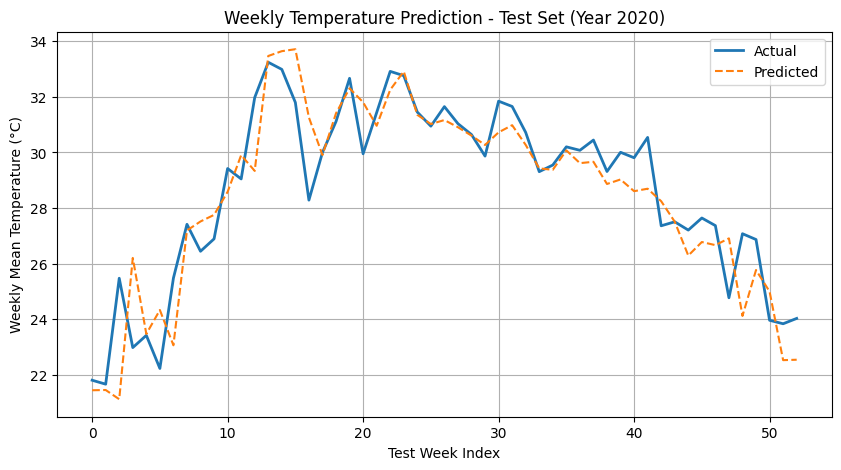

In [3]:
# 9. Feature Importance (Insight for Report)
importances = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n=== Feature Importance ===")
print(importances)

# 10. Actual vs Predicted Plot (Test Set)
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(y_pred, label="Predicted", linestyle="--")
plt.title("Weekly Temperature Prediction - Test Set (Year 2020)")
plt.xlabel("Test Week Index")
plt.ylabel("Weekly Mean Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()


## Model Visualization and Example Prediction

The plot above compares the **actual** vs **predicted** weekly mean temperatures for the test year (**2020**).  
A close alignment between the lines indicates strong predictive accuracy, especially due to:
- the use of **lagged features**, and  
- incorporation of **humidity and time-based features** (`YEAR`, `MONTH`, `WEEK`).

---


In [4]:
def predict_week(year, month, week, hum_mean, lag_temp, lag_hum):
    """
    Predict weekly mean temperature for a given (year, month, week) using
    weekly mean humidity and lagged features.
    """
    data = pd.DataFrame([{
        'HUM_MEAN': hum_mean,
        'MONTH': month,
        'WEEK': week,
        'YEAR': year,
        'TEMP_MEAN_LAG_1': lag_temp,
        'HUM_MEAN_LAG_1': lag_hum
    }])

    # Ensure correct ordering
    data = data[features]

    return model.predict(data)[0]


# Example usage:
example_row = weekly_df_lagged[(weekly_df_lagged['YEAR'] == 2020) & 
                               (weekly_df_lagged['WEEK'] == 21)]

lag_row = weekly_df_lagged[(weekly_df_lagged['YEAR'] == 2020) & 
                            (weekly_df_lagged['WEEK'] == 20)]

lag_temp = lag_row['TEMP_MEAN'].values[0]
lag_hum = lag_row['HUM_MEAN'].values[0]
hum_mean_example = example_row['HUM_MEAN'].values[0]

print(predict_week(2020, 5, 21, hum_mean_example, lag_temp, lag_hum))

31.805833333333347


### Example Prediction for a Specific Week

To generate a temperature forecast for a specific week, the model requires:

- **Temporal features**: Year, Month, Week number  
- **Environmental input**: Expected mean humidity for that week  
- **Historical context (lagged features)**:
  - Mean temperature of the previous week
  - Mean humidity of the previous week

These lagged values capture temporal dependencies in weather patterns and enable prediction even when real-time sensors fail—allowing the system to continue regulating air conditioning based on estimated temperature values.
